In [1]:
import numpy as np
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import pandas as pd
import xarray as xr
from scipy import signal
import cftime
import datetime
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
import seaborn as sns; sns.set(color_codes=True)

from sklearn.metrics.pairwise import haversine_distances

grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [2]:
# Get observations from NSIDC bootstrap, regridded to match CICE grid
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
# ice_file = 'seaice_conc_daily_nh_1979-2018_cicegrid.nc' # name of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2019_cicegrid.nc' # name of regridded file
ice_file_originalgrid = 'seaice_conc_daily_nh_1979-2019.nc' # name of original file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')
boot_native = (xr.open_dataset(path+ice_file_originalgrid)).rename_vars(seaice_conc_cdr='aice_d')

dist_sat12 = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2012.nc') # output from dist formula
dist_sat12_bt = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2012.nc') 
dist_sat12_nt = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2012.nc')

dist_sat15 = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2015.nc') # output from dist formula
dist_sat15_bt = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2015.nc') 
dist_sat15_nt = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2015.nc')

dist_sat17 = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2017.nc') # output from dist formula
dist_sat17_bt = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2017.nc') 
dist_sat17_nt = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2017.nc')

dist_sat18 = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2018.nc') # output from dist formula
dist_sat18_bt = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2018.nc') 
dist_sat18_nt = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2018.nc')


# Read in mooring data for 4 time periods from 3 files
bdir = '/glade/work/lettier/BGEP/'
files = ['BGEP-A_AWAC_2012-2013_converted.nc',
         'BGEP-D_AWAC_2014-2015_converted.nc',
         'BGEP-A_AWAC_2017-2018_converted.nc',]        
bounds = [['2012-08','2012-11'],
          ['2015-08','2015-10'],
          ['2017-10','2017-12'],
          ['2018-07','2018-10']]

bds12 = xr.open_dataset(bdir+files[0]).sel(time=slice(bounds[0][0],bounds[0][1]))
bds15 = xr.open_dataset(bdir+files[1]).sel(time=slice(bounds[1][0],bounds[1][1]))
bds17 = xr.open_dataset(bdir+files[2]).sel(time=slice(bounds[2][0],bounds[2][1]))
bds18 = xr.open_dataset(bdir+files[2]).sel(time=slice(bounds[3][0],bounds[3][1]))

# pre 2018 model data
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
ice_file = 'cicefsdww3i.cice.h.concat.0068-0084.nc' # monthly ice output
wave_file = 'cicefsdww3i.ww3.sigheight.2000-2016.nc' # daily wave output
mwds = xr.open_dataset(mdir_adj+wave_file)
mwds = mwds.set_coords(['longitude','latitude'])

# 2018 model output
ww_00_16 = xr.open_dataset(
    '/glade/work/vcooper/BGEP_vtc/cicefsdww3i.ww3.sigheight.2000-2016.nc').set_coords(['longitude','latitude']) # 6 hourly wave output
ww18 = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/ww3.2018_sigheight.nc').set_coords(['longitude','latitude']) # rerun
ww0019 = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/cicefsdww3i.ww3.sigheight.2000-2019.nc').set_coords(['longitude','latitude']) # 6h

# cice18 = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/cicefsdww3i.cice.h1.2018.nc') # 2018 bad output
cice18 = xr.open_dataset('/glade/work/lettier/CICE/cicefsdww3i_rerun/cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
start = pd.Timestamp(ww18.time.values[0])
end = pd.Timestamp(ww18.time.values[-1])
t = np.linspace(start.value, end.value, len(cice18.time))
t = (pd.to_datetime(t)).round('D')
cice18 = cice18.assign_coords(time=t) # adjust time to be year 2018
dist_cice18_6h = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/cice_iceedgedistance_2018.nc') # output from dist formula

# SODA data
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_A_sigWaves.mat_converted.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_B_sigWaves.mat_converted.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_C_sigWaves.mat_converted.nc')
sodaAice = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_A_sigIce.mat_converted.nc')
sodaBice = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_B_sigIce.mat_converted.nc')
sodaCice = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_C_sigIce.mat_converted.nc')
# sodaA = (sodaA.assign(iceDraftAST=sodaAice.iceDraftAST)).assign(iceDraftLE=sodaAice.iceDraftLE) # add icedraft vars
# sodaB = (sodaB.assign(iceDraftAST=sodaBice.iceDraftAST)).assign(iceDraftLE=sodaBice.iceDraftLE)
# sodaC = (sodaC.assign(iceDraftAST=sodaCice.iceDraftAST)).assign(iceDraftLE=sodaCice.iceDraftLE) 

# SWIFT data
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 

for i,key in enumerate(swift_dict):
    
    ## get corresponding grid cells for each swift
    templat = np.tile(swift_dict[key].lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(swift_dict[key].lon.values.mean(),
                  cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    index = np.where(dist == np.min(dist))
    index[0][0] = index[0][0] - 300 # adjust for limited latslice of distance data
    
    ## get satellite distance interpolated to swift times
    dist_sat15_swift = dist_sat15[:,index[0][0],index[1][0]].interp(
        time=swift_dict[key].time.values)
    swift_dist[key] = dist_sat15_swift
    
    # bt
    dist_sat15_swift = dist_sat15_bt[:,index[0][0],index[1][0]].interp(
        time=swift_dict[key].time.values)
    swift_dist_bt[key] = dist_sat15_swift

    # nt
    dist_sat15_swift = dist_sat15_nt[:,index[0][0],index[1][0]].interp(
        time=swift_dict[key].time.values)
    swift_dist_nt[key] = dist_sat15_swift


timeslice = slice('2018-01-01','2018-12-31')
latslice = slice(300,384)

In [4]:
ww18t = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/ww3.2018_sigheight.nc').set_coords(['longitude','latitude'])
ww18t

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 384, time: 1460)
Coordinates:
    longitude  (nj, ni) float32 ...
    latitude   (nj, ni) float32 ...
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T18:00:00
Dimensions without coordinates: ni, nj
Data variables:
    MAPSTA     (nj, ni) int16 ...
    dpt        (time, nj, ni) float32 ...
    uwnd       (time, nj, ni) float32 ...
    vwnd       (time, nj, ni) float32 ...
    ast        (time, nj, ni) float32 ...
    ice        (time, nj, ni) float32 ...
    hs         (time, nj, ni) float32 ...
    lm         (time, nj, ni) float32 ...
    t02        (time, nj, ni) float32 ...
    t0m1       (time, nj, ni) float32 ...
    t01        (time, nj, ni) float32 ...
    fp         (time, nj, ni) float32 ...
    dir        (time, nj, ni) float32 ...
    spr        (time, nj, ni) float32 ...
    dp         (time, nj, ni) float32 ...
Attributes:
    WAVEWATCH_III_version_number:  5.16
    WAVEWATCH_III_switches:        F90 NOGRB NOPA LRB4 NC4 PR3 UQ FLX0 LN1 ST...
    product_name:                  ww3.20180101.nc
    area:                          POP 1 degree grid (gx1v6b)
    latitude_resolution:           n/a
    longitude_resolution:          n/a
    southernmost_latitude:         -79.22052
    northernmost_latitude:         89.70641
    westernmost_longitude:         1.4731102E-02
    easternmost_longitude:         359.9960
    minimum_altitude:              -12000 m
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2018-01-01 00:00:00
    stop_date:                     2018-01-01 18:00:00
    history:                       Tue Jun  9 11:42:23 2020: ncrename -d long...
    NCO:                           netCDF Operators version 4.7.9 (Homepage =...

In [7]:
ww18

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 384, time: 1456)
Coordinates:
    longitude  (nj, ni) float32 ...
    latitude   (nj, ni) float32 ...
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-30T18:00:00
Dimensions without coordinates: ni, nj
Data variables:
    MAPSTA     (nj, ni) int16 ...
    dpt        (time, nj, ni) float32 ...
    uwnd       (time, nj, ni) float32 ...
    vwnd       (time, nj, ni) float32 ...
    ast        (time, nj, ni) float32 ...
    ice        (time, nj, ni) float32 ...
    hs         (time, nj, ni) float32 ...
    lm         (time, nj, ni) float32 ...
    t02        (time, nj, ni) float32 ...
    t0m1       (time, nj, ni) float32 ...
    t01        (time, nj, ni) float32 ...
    fp         (time, nj, ni) float32 ...
    dir        (time, nj, ni) float32 ...
    spr        (time, nj, ni) float32 ...
    dp         (time, nj, ni) float32 ...
Attributes:
    WAVEWATCH_III_version_number:  5.16
    WAVEWATCH_III_switches:        F90 NOGRB NOPA LRB4 NC4 PR3 UQ FLX0 LN1 ST...
    product_name:                  ww3.20180101.nc
    area:                          POP 1 degree grid (gx1v6b)
    latitude_resolution:           n/a
    longitude_resolution:          n/a
    southernmost_latitude:         -79.22052
    northernmost_latitude:         89.70641
    westernmost_longitude:         1.4731102E-02
    easternmost_longitude:         359.9960
    minimum_altitude:              -12000 m
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2018-01-01 00:00:00
    stop_date:                     2018-01-01 18:00:00
    history:                       Wed Apr 29 17:19:29 2020: ncrename -d long...
    NCO:                           netCDF Operators version 4.7.9 (Homepage =...

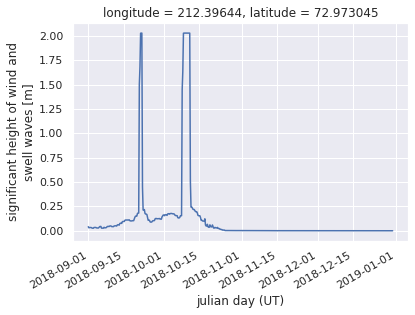

In [8]:
# sodaA.sigwaveheight.plot()
ww18t.hs.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(label='ww3')

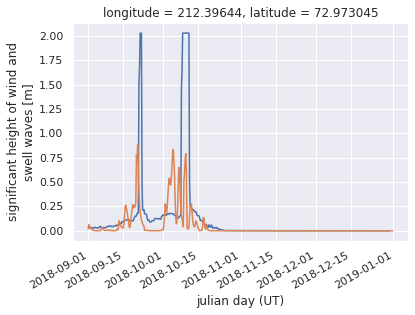

In [6]:
ww18.hs.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(label='ww3')
ww18t.hs.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(label='new')

## Run background calculations for distance from satellite data
Do this for 2012, 2015, 2017

In [15]:
## Updated version to 15% ice concentration threshold
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
    lats = iceconc_input.TLAT.values # cice output version (including regridded satellite)
    lons = iceconc_input.TLON.values # cice output version
#     lats = iceconc_input.latitude.values # ww3 output version
#     lons = iceconc_input.longitude.values # ww3 output version


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    
    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.15))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # get max icefrac of 4 neighbor cells at each open water cell
    iceneighbormax = np.nanmax(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with ice neighbor>15% # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighbormax>0.15)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice > 15%
    icewhere = np.where(icefracsnp>0.15)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point
    
#     consider adding something like this and removing the loop? so it outputs xarray
#     dist_series = iceconc_input.copy()
#     dist_series.values = np.array(disttest_v04)


    return(distances)

In [7]:
%%time
# calculate distances for 2012 cice
timeslice = slice('2012-01-01','2012-12-31')
latslice = slice(300,384)

# # # UNCOMMENT THIS TO RESTART ALL, approx 7 min
# dist_cice18_6h = [icedistance(aice) for aice in (cice18_6h_aice.sel(time=timeslice,nj=latslice))]
# dist_cice18_6h = (xr.DataArray(dist_cice18_6h)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_cice18_6h = xr.DataArray(dist_cice18_6h,coords=cice18_6h_aice.sel(nj=latslice).coords)

# dist_sat12 = [icedistance(aice) for aice in (boot.aice_d.sel(time=timeslice,nj=latslice))]
# dist_sat12 = (xr.DataArray(dist_sat12)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat12 = xr.DataArray(dist_sat12,coords=boot.aice_d.sel(time=timeslice,nj=latslice).coords)

# dist_sat12_bt = [icedistance(aice) for aice in (boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice))]
# dist_sat12_bt = (xr.DataArray(dist_sat12_bt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat12_bt = xr.DataArray(dist_sat12_bt,coords=boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

# dist_sat12_nt = [icedistance(aice) for aice in (boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice))]
# dist_sat12_nt = (xr.DataArray(dist_sat12_nt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat12_nt = xr.DataArray(dist_sat12_nt,coords=boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarnin

CPU times: user 3min 22s, sys: 595 ms, total: 3min 23s
Wall time: 3min 49s


In [8]:
# write distances to netcdf
# cice model
# new_filename = './cice_iceedgedistance_2018.nc'
# print ('saving to ', new_filename)

# dist_cice18_6h.to_netcdf(path=new_filename)
# print ('finished saving')

# satellite
# new_filename = './sat_iceedgedistance_2012.nc'
# print ('saving to ', new_filename)

# dist_sat12.to_netcdf(path=new_filename)
# print ('finished saving')

# # satellite bt
# new_filename = './sat_iceedgedistance_bt_2012.nc'
# print ('saving to ', new_filename)

# dist_sat12_bt.to_netcdf(path=new_filename)
# print ('finished saving')

# # satellite nt
# new_filename = './sat_iceedgedistance_nt_2012.nc'
# print ('saving to ', new_filename)

# dist_sat12_nt.to_netcdf(path=new_filename)
# print ('finished saving')

## DONT FORGET TO COPY FILES IN CHEYENNE TO DESIRED DIRECTORY ##

saving to  ./sat_iceedgedistance_2012.nc
finished saving
saving to  ./sat_iceedgedistance_bt_2012.nc
finished saving
saving to  ./sat_iceedgedistance_nt_2012.nc
finished saving


In [13]:
%%time
# calculate distances for 2012 cice
timeslice = slice('2017-01-01','2017-12-31')
latslice = slice(300,384)

# # # UNCOMMENT THIS TO RESTART ALL, approx 7 min
# dist_cice18_6h = [icedistance(aice) for aice in (cice18_6h_aice.sel(time=timeslice,nj=latslice))]
# dist_cice18_6h = (xr.DataArray(dist_cice18_6h)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_cice18_6h = xr.DataArray(dist_cice18_6h,coords=cice18_6h_aice.sel(nj=latslice).coords)

# dist_sat = [icedistance(aice) for aice in (boot.aice_d.sel(time=timeslice,nj=latslice))]
# dist_sat = (xr.DataArray(dist_sat)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat = xr.DataArray(dist_sat,coords=boot.aice_d.sel(time=timeslice,nj=latslice).coords)

# dist_sat_bt = [icedistance(aice) for aice in (boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice))]
# dist_sat_bt = (xr.DataArray(dist_sat_bt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat_bt = xr.DataArray(dist_sat_bt,coords=boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

# dist_sat_nt = [icedistance(aice) for aice in (boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice))]
# dist_sat_nt = (xr.DataArray(dist_sat_nt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat_nt = xr.DataArray(dist_sat_nt,coords=boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


CPU times: user 3min 24s, sys: 405 ms, total: 3min 25s
Wall time: 3min 45s


In [14]:
# write distances to netcdf
# cice model
# new_filename = './cice_iceedgedistance_2018.nc'
# print ('saving to ', new_filename)

# dist_cice18_6h.to_netcdf(path=new_filename)
# print ('finished saving')

# # satellite
# new_filename = './sat_iceedgedistance_2017.nc'
# print ('saving to ', new_filename)

# dist_sat.to_netcdf(path=new_filename)
# print ('finished saving')

# # satellite bt
# new_filename = './sat_iceedgedistance_bt_2017.nc'
# print ('saving to ', new_filename)

# dist_sat_bt.to_netcdf(path=new_filename)
# print ('finished saving')

# # satellite nt
# new_filename = './sat_iceedgedistance_nt_2017.nc'
# print ('saving to ', new_filename)

# dist_sat_nt.to_netcdf(path=new_filename)
# print ('finished saving')

# ## DONT FORGET TO COPY FILES IN CHEYENNE TO DESIRED DIRECTORY ##

saving to  ./sat_iceedgedistance_2017.nc
finished saving
saving to  ./sat_iceedgedistance_bt_2017.nc
finished saving
saving to  ./sat_iceedgedistance_nt_2017.nc
finished saving


In [20]:
%%time
# calculate distances for 2019
timeslice = slice('2013-01-01','2013-12-31')
latslice = slice(300,384)

# # UNCOMMENT THIS TO RESTART ALL
dist_sat = [icedistance(aice) for aice in (boot.aice_d.sel(time=timeslice,nj=latslice))]
dist_sat = (xr.DataArray(dist_sat)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat = xr.DataArray(dist_sat,coords=boot.aice_d.sel(time=timeslice,nj=latslice).coords)

dist_sat_bt = [icedistance(aice) for aice in (boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice))]
dist_sat_bt = (xr.DataArray(dist_sat_bt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat_bt = xr.DataArray(dist_sat_bt,coords=boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

dist_sat_nt = [icedistance(aice) for aice in (boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice))]
dist_sat_nt = (xr.DataArray(dist_sat_nt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat_nt = xr.DataArray(dist_sat_nt,coords=boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 3min 17s, sys: 371 ms, total: 3min 18s
Wall time: 3min 37s


In [21]:
## satellite
new_filename = './sat_iceedgedistance_2013.nc'
print ('saving to ', new_filename)

dist_sat.to_netcdf(path=new_filename)
print ('finished saving')

# satellite bt
new_filename = './sat_iceedgedistance_bt_2013.nc'
print ('saving to ', new_filename)

dist_sat_bt.to_netcdf(path=new_filename)
print ('finished saving')

# satellite nt
new_filename = './sat_iceedgedistance_nt_2013.nc'
print ('saving to ', new_filename)

dist_sat_nt.to_netcdf(path=new_filename)
print ('finished saving')

# ## DONT FORGET TO COPY FILES IN CHEYENNE TO DESIRED DIRECTORY ##

saving to  ./sat_iceedgedistance_2013.nc
finished saving
saving to  ./sat_iceedgedistance_bt_2013.nc
finished saving
saving to  ./sat_iceedgedistance_nt_2013.nc
finished saving


In [11]:
%%time
# calculate distances for 2012 cice
timeslice = slice('2015-01-01','2015-12-31')
latslice = slice(300,384)

# # # UNCOMMENT THIS TO RESTART ALL, approx 7 min
# dist_cice18_6h = [icedistance(aice) for aice in (cice18_6h_aice.sel(time=timeslice,nj=latslice))]
# dist_cice18_6h = (xr.DataArray(dist_cice18_6h)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_cice18_6h = xr.DataArray(dist_cice18_6h,coords=cice18_6h_aice.sel(nj=latslice).coords)

# dist_sat = [icedistance(aice) for aice in (boot.aice_d.sel(time=timeslice,nj=latslice))]
# dist_sat = (xr.DataArray(dist_sat)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat = xr.DataArray(dist_sat,coords=boot.aice_d.sel(time=timeslice,nj=latslice).coords)

# dist_sat_bt = [icedistance(aice) for aice in (boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice))]
# dist_sat_bt = (xr.DataArray(dist_sat_bt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat_bt = xr.DataArray(dist_sat_bt,coords=boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

# dist_sat_nt = [icedistance(aice) for aice in (boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice))]
# dist_sat_nt = (xr.DataArray(dist_sat_nt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat_nt = xr.DataArray(dist_sat_nt,coords=boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


CPU times: user 3min 27s, sys: 350 ms, total: 3min 27s
Wall time: 3min 47s


In [12]:
# write distances to netcdf
# cice model
# new_filename = './cice_iceedgedistance_2018.nc'
# print ('saving to ', new_filename)

# dist_cice18_6h.to_netcdf(path=new_filename)
# print ('finished saving')

# satellite
# new_filename = './sat_iceedgedistance_2015.nc'
# print ('saving to ', new_filename)

# dist_sat.to_netcdf(path=new_filename)
# print ('finished saving')

# # satellite bt
# new_filename = './sat_iceedgedistance_bt_2015.nc'
# print ('saving to ', new_filename)

# dist_sat_bt.to_netcdf(path=new_filename)
# print ('finished saving')

# # satellite nt
# new_filename = './sat_iceedgedistance_nt_2015.nc'
# print ('saving to ', new_filename)

# dist_sat_nt.to_netcdf(path=new_filename)
# print ('finished saving')

# ## DONT FORGET TO COPY FILES IN CHEYENNE TO DESIRED DIRECTORY ##

saving to  ./sat_iceedgedistance_2015.nc
finished saving
saving to  ./sat_iceedgedistance_bt_2015.nc
finished saving
saving to  ./sat_iceedgedistance_nt_2015.nc
finished saving


In [18]:
%%time
# calculate distances for 2019
timeslice = slice('2016-01-01','2016-12-31')
latslice = slice(300,384)

# # UNCOMMENT THIS TO RESTART ALL
dist_sat = [icedistance(aice) for aice in (boot.aice_d.sel(time=timeslice,nj=latslice))]
dist_sat = (xr.DataArray(dist_sat)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat = xr.DataArray(dist_sat,coords=boot.aice_d.sel(time=timeslice,nj=latslice).coords)

dist_sat_bt = [icedistance(aice) for aice in (boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice))]
dist_sat_bt = (xr.DataArray(dist_sat_bt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat_bt = xr.DataArray(dist_sat_bt,coords=boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

dist_sat_nt = [icedistance(aice) for aice in (boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice))]
dist_sat_nt = (xr.DataArray(dist_sat_nt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat_nt = xr.DataArray(dist_sat_nt,coords=boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 3min 14s, sys: 413 ms, total: 3min 14s
Wall time: 3min 35s


In [19]:
## satellite
new_filename = './sat_iceedgedistance_2016.nc'
print ('saving to ', new_filename)

dist_sat.to_netcdf(path=new_filename)
print ('finished saving')

# satellite bt
new_filename = './sat_iceedgedistance_bt_2016.nc'
print ('saving to ', new_filename)

dist_sat_bt.to_netcdf(path=new_filename)
print ('finished saving')

# satellite nt
new_filename = './sat_iceedgedistance_nt_2016.nc'
print ('saving to ', new_filename)

dist_sat_nt.to_netcdf(path=new_filename)
print ('finished saving')

# ## DONT FORGET TO COPY FILES IN CHEYENNE TO DESIRED DIRECTORY ##

saving to  ./sat_iceedgedistance_2016.nc
finished saving
saving to  ./sat_iceedgedistance_bt_2016.nc
finished saving
saving to  ./sat_iceedgedistance_nt_2016.nc
finished saving


In [16]:
%%time
# calculate distances for 2019
timeslice = slice('2019-01-01','2019-12-31')
latslice = slice(300,384)

# # UNCOMMENT THIS TO RESTART ALL
dist_sat = [icedistance(aice) for aice in (boot.aice_d.sel(time=timeslice,nj=latslice))]
dist_sat = (xr.DataArray(dist_sat)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat = xr.DataArray(dist_sat,coords=boot.aice_d.sel(time=timeslice,nj=latslice).coords)

dist_sat_bt = [icedistance(aice) for aice in (boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice))]
dist_sat_bt = (xr.DataArray(dist_sat_bt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat_bt = xr.DataArray(dist_sat_bt,coords=boot.goddard_bt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

dist_sat_nt = [icedistance(aice) for aice in (boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice))]
dist_sat_nt = (xr.DataArray(dist_sat_nt)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_sat_nt = xr.DataArray(dist_sat_nt,coords=boot.goddard_nt_seaice_conc.sel(time=timeslice,nj=latslice).coords)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


CPU times: user 3min 11s, sys: 482 ms, total: 3min 12s
Wall time: 3min 34s


In [17]:
## satellite
new_filename = './sat_iceedgedistance_2019.nc'
print ('saving to ', new_filename)

dist_sat.to_netcdf(path=new_filename)
print ('finished saving')

# satellite bt
new_filename = './sat_iceedgedistance_bt_2019.nc'
print ('saving to ', new_filename)

dist_sat_bt.to_netcdf(path=new_filename)
print ('finished saving')

# satellite nt
new_filename = './sat_iceedgedistance_nt_2019.nc'
print ('saving to ', new_filename)

dist_sat_nt.to_netcdf(path=new_filename)
print ('finished saving')

# ## DONT FORGET TO COPY FILES IN CHEYENNE TO DESIRED DIRECTORY ##

saving to  ./sat_iceedgedistance_2019.nc
finished saving
saving to  ./sat_iceedgedistance_bt_2019.nc
finished saving
saving to  ./sat_iceedgedistance_nt_2019.nc
finished saving


## Calculate distances for full model run 2000-2019

In [15]:
ww0019.coords

Coordinates:
    longitude  (nj, ni) float32 ...
    latitude   (nj, ni) float32 ...
  * time       (time) datetime64[ns] 2000-01-01 ... 2019-12-31T18:00:00

In [16]:
%%time
# calculate distances for model run
# timeslice = slice('2015-01-01','2015-12-31')
latslice = slice(300,384)

dist_model = [icedistance(aice) for aice in (ww0019.ice.sel(nj=latslice))]
dist_model = (xr.DataArray(dist_model)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
dist_model = xr.DataArray(dist_model,coords=ww0019.sel(nj=latslice).coords)


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 1h 32min 34s, sys: 5.65 s, total: 1h 32min 40s
Wall time: 1h 33min 14s


In [17]:
# write distances to netcdf
# cice model
new_filename = './model_iceedgedistance_2000-2019.nc'
print ('saving to ', new_filename)

dist_model.to_netcdf(path=new_filename)
print ('finished saving')

## DONT FORGET TO COPY FILES IN CHEYENNE TO DESIRED DIRECTORY ##

saving to  ./model_iceedgedistance_2000-2019.nc
finished saving
